In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pyfits
import astropy.wcs as wcs
import math

from scipy.odr import ODR, Model, Data, RealData
import scipy.ndimage
import random

## input
vmin = 100. ## still check this argument with the PDR toolbox
sampleSize = 10000 ## for bootstrapping
corrFactSize = 2. ## based on test of physical size (KEEP THIS?)

dtheta = 15. ## in degrees
numCuts = int(180./dtheta + 0.5)
print(numCuts)

## make dictionary with distance (distance in parsec) and age (min, estimate, max) (in Myr) and velocities that define the 
## IMPORTANT NOTE: M42 has width x2, because only fits blue wings (see spectrum), so take full FWHM ##
names = {
    'm16_CII_final_20_8_0p5_clean': [1706.,0.2,1.3,0.2,5.,11.,33.,41.,0.5*2.35*7.0,0.5*2.35*0.008,'M16'],
    'm17_CII_final_20_8_0p5_clean': [1900.,0.15,0.58,0.15,-11.,8.,36.,52.,0.5*2.35*10.6,0.5*2.35*0.05,'M17'],
    'RCW120_CII_final_20_8_0p5_clean': [1680.,1.2,1.2,1.8,-30.,-14.,-2.,18.,0.5*2.35*5.3,0.5*2.35*0.2,'RCW 120'],
    'RCW79_CII_final_20_8_0p5_clean': [3900.,0.5,2.3,0.5,-70.,-54.,-40.,-26.,0.5*2.35*7.9,0.5*2.35*0.1,'RCW 79'],
    'RCW36_CII_final_20_8_0p5_clean': [950.,0.6,1.1,0.6,-12.,-1.,13.,22.,0.5*2.35*6.0,0.5*2.35*0.08,'RCW 36'],
    #'W40_CII_final_20_8_0p5_clean': [502.,0.9,0.9,0.9,-14.,1.,13.,23.,0.5*2.35*8.1,'W40'],
    'NGC7538_CII_final_20_8_0p5_clean': [2650.,0.85,2.2,0.85,-80.,-64.,-47.,-33.,0.5*2.35*8.5,0.5*2.35*0.2,'NGC 7538'],
    'RCW49_CII_final_20_8_0p5_clean': [4160.,0.75,1.25,0.75,-31.,-14.,23.,39.,0.5*2.35*11.4,0.5*2.35*0.5,'RCW 49'],
    'OrionA_CII_final_20_8_0p5_clean': [414.,0.5,2.5,0.5,-12.,4.,14.,25.,2.35*5.4,2.35*0.03,'M42'], 
}
## age M16: Stoop+2023
## age M17: Hanson+1997 (look for better)
## age RCW120: Martins+2010
## age RCW79: Martins+2010
## age RCW 36: Ellerbroeck+2013
## age W40: 0.9 Myr+-0.9 Comeron+2022 (distance: 502 pc)
## NGC 7538: Puga+2010: age spread (0.5-2.2 Myr, median: 1.35): Based on maximum age of 60 solar mass star and PMS stars
## RCW 49: age: Zeidler (age range: 0.5-2.0 Myr, middle: 1.25), distance: Cantat-Gaudin
## M42: distance: Menten+2007, age: 2-3 Myr (Da Rio et al.)

## extract region M42 in Orion
x1_M42 = 260
x2_M42 = 260+720
y1_M42 = 20
y2_M42 = 20+640

12


In [2]:
## calculate chance all 8 clusters are younger than 0.6 Myr or 1 Myr
## assuming the typical age of a cluster is 2.5 Myr

## 1 Myr
odds = 0.4**8 ## 1 Myr/2.5 Myr
print(odds)  ## > 3 sigma

odds = (0.6/2.5)**8
print(odds)  ## > 4 sigma

0.0006553600000000003
1.1007531417599997e-05


In [3]:
## define the linear function
def linFunc(beta, x):
    y = beta[0]*x + beta[1]
    return y

def linFunc_noOff(beta, x):
    y = beta[0]*x
    return y

In [4]:
## find size of the region with different cuts
## see: https://stackoverflow.com/questions/7878398/how-to-extract-an-arbitrary-line-of-values-from-a-numpy-array
def avSizeFromCuts(xb,xe,yb,ye,theta,numCuts_f,dat,wcs_info,nameSource):
    zis = []
    maxDiffs = []
    
    x_cent = xb + 0.5*(xe-xb)
    y_cent = yb + 0.5*(ye-yb)
    mid_angle = np.arctan(y_cent/x_cent)
    #print(mid_angle)
    
    ## start plotting
    plt.clf()
    fig, ax = plt.subplots()
    ax1 = fig.add_subplot(111, projection=wcs_info)
    im = ax1.imshow(dat, origin='lower', vmin=0., cmap = 'jet')
    
    plt.xlim([xb, xe])
    plt.ylim([yb, ye])
    plt.xlabel('RA [J2000]')
    plt.ylabel('DEC [J2000]')

    ## get the intensity cut and add it to the plot
    for i in range(0,numCuts_f):
        angle_rad = i*theta*np.pi/180.
        a = math.tan(angle_rad)
        #print(a)
        
        x0 = xb + 3
        x1 = xe - 3
        y0 = y_cent + a*(x0-x_cent)
        y1 = y_cent + a*(x1-x_cent)
        if(mid_angle < angle_rad < np.pi-mid_angle):
            y0 = yb + 3
            y1 = ye - 3
            x0 = x_cent + (y0-y_cent)/a + 1
            x1 = x_cent + (y1-y_cent)/a - 1
        num = int(2.*np.sqrt((x1-x0)**2 + (y1-y0)**2) + 0.5)
        print(num)
        x, y = np.linspace(x0,x1,num), np.linspace(y0, y1, num)
        #print(x.astype(np.int))
        #zi = scipy.ndimage.map_coordinates(dat, np.vstack((x,y)))
        zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]
        #print(zi)
        zis.append(zi)
        
        midZi = len(zi)/2
        #zi[zi<vmin] = np.nan
        #inds = np.argwhere(~np.isnan(zi))
        zi[np.isnan(zi)] = 0.
        inds = np.argwhere(zi>vmin)
        #print(inds)
        try:
            minInd = np.nanmin(inds)
            maxInd = np.nanmax(inds)
            if(minInd<midZi and maxInd>midZi):
                maxDiffs.append((maxInd-minInd)*pixSize)
        except:
            print("Not possible to estimate size along this axis")
    
        ax1.plot([x0, x1], [y0, y1], 'ro-')
    
    box_info = ax1.get_position()
    print(box_info)
    pos_x = box_info.get_points()[1][0]
    pos_ymin = box_info.get_points()[0][1]
    pos_ymax = box_info.get_points()[1][1]
    print(pos_ymax)
    #cbaraxis = fig.add_axes([0.76,0.125,0.02,0.755])
    if(nameSource == 'RCW36_CII_final_20_8_0p5_clean'):
        cbaraxis = fig.add_axes([pos_x,pos_ymin,0.02,0.59])
    else:
        cbaraxis = fig.add_axes([pos_x,pos_ymin,0.02,0.755])
    cbar = fig.colorbar(im, cax=cbaraxis)
    cbar.set_label('$\int$T$_{mb}$dv (K km s$^{-1}$)', labelpad=15.,rotation=270.)
    
    ax.axis('off')
    #plt.savefig('../plotsOutflow/integratedMaps_cuts/'+nameSource+'integrated_map+cuts.pdf',dpi=300)
    plt.show()
    plt.clf()
    
    ## intensity profiles
    for zi in zis:
        plt.plot(zi)
    plt.xlabel('distance (pixels)')
    plt.ylabel('T$_{mb}$ (K)')
    plt.show()
    plt.clf()
    
    return 0.5*np.nanmean(maxDiffs), 0.5*np.nanstd(maxDiffs) ## To get the radius + standard deviation

Filename: ../allRegions/final/m16_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (295, 283)   float32   
1706.0
Filename: ../allRegions/m16_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (295, 283, 200)   float32   


578
598
667
781
638
573
554
575
642
786
667
598
Bbox(x0=0.25016195524146057, y0=0.125, x1=0.7748380447585395, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

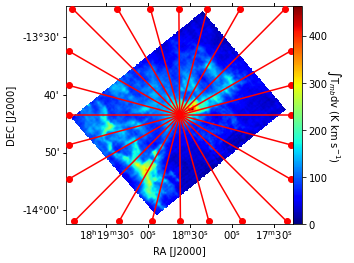

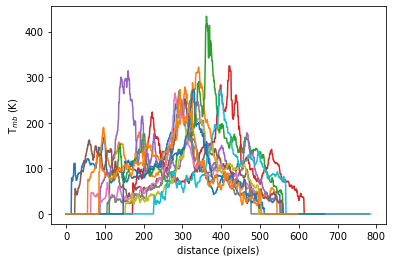

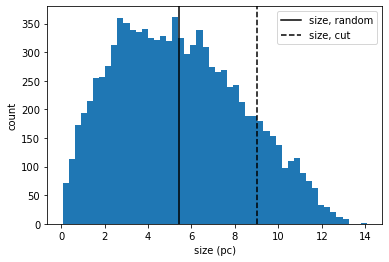

No handles with labels found to put in legend.


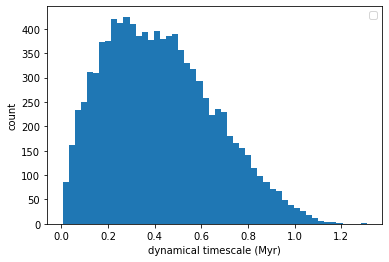

Filename: ../allRegions/final/m17_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (191, 191)   float32   
1900.0
Filename: ../allRegions/m17_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (191, 191, 200)   float32   


370
383
427
523
425
382
370
384
429
523
427
383
Bbox(x0=0.26083333333333336, y0=0.125, x1=0.7641666666666667, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

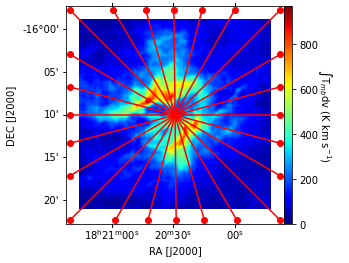

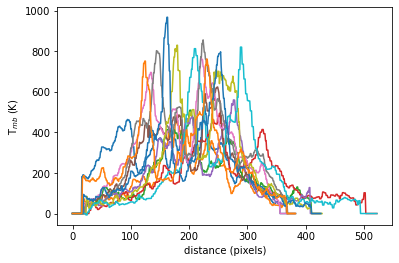

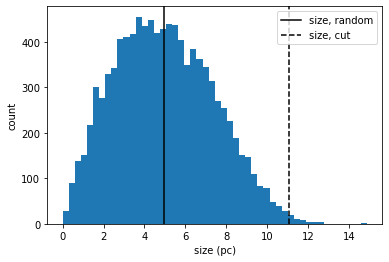

No handles with labels found to put in legend.


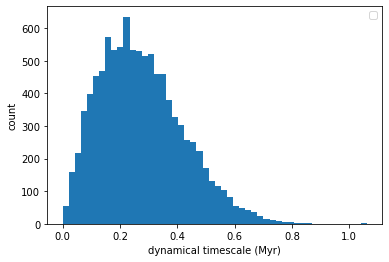

Filename: ../allRegions/final/RCW120_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (136, 137)   float32   
1680.0
Filename: ../allRegions/RCW120_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (136, 137, 320)   float32   


260
269
Not possible to estimate size along this axis
300
368
301
270
262
272
305
368
300
269
Bbox(x0=0.2626703163017032, y0=0.125, x1=0.7623296836982969, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

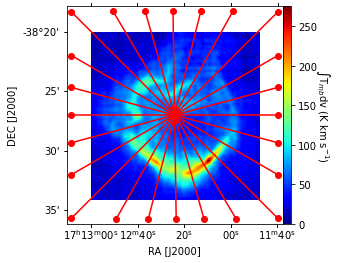

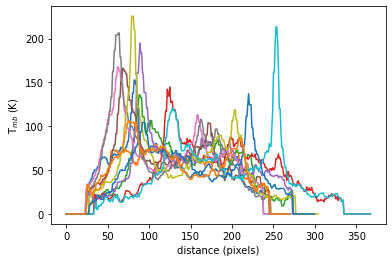

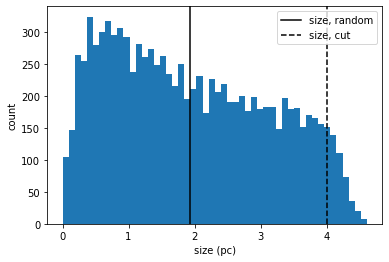

No handles with labels found to put in legend.


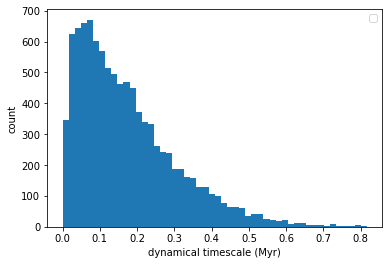

Filename: ../allRegions/final/RCW79_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (188, 188)   float32   
3900.0
Filename: ../allRegions/RCW79_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   


364
377
420
515
418
376
364
378
422
515
420
377
Bbox(x0=0.26083333333333336, y0=0.125, x1=0.7641666666666667, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

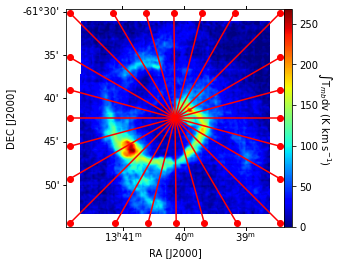

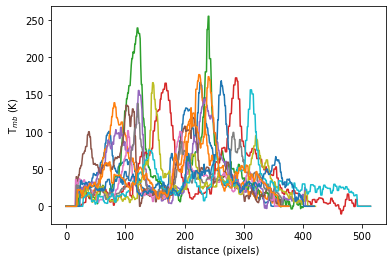

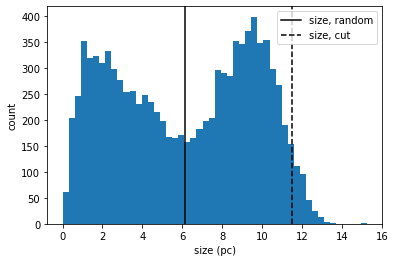

No handles with labels found to put in legend.


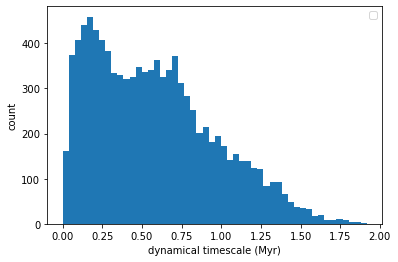

Filename: ../allRegions/final/RCW36_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (108, 55)   float32   
950.0
Filename: ../allRegions/RCW36_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 55, 901)   float32   


204
211
193
136
111
100
98
103
115
141
199
211
Bbox(x0=0.125, y0=0.20649305555555547, x1=0.9, y1=0.7985069444444446)
0.7985069444444446


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

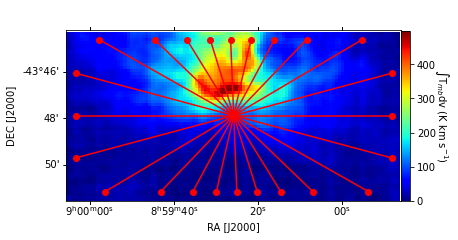

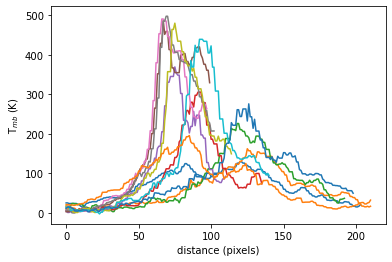

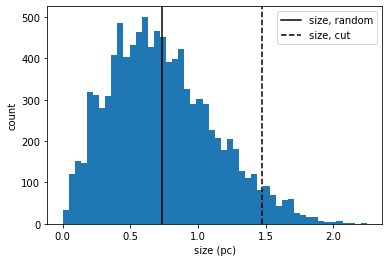

No handles with labels found to put in legend.


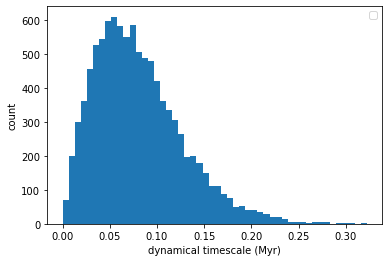

Filename: ../allRegions/final/NGC7538_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (108, 104)   float32   
2650.0
Filename: ../allRegions/NGC7538_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (108, 104, 901)   float32   


204
211
236
274
224
202
196
204
228
280
236
211
Bbox(x0=0.25115384615384617, y0=0.125, x1=0.7738461538461539, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

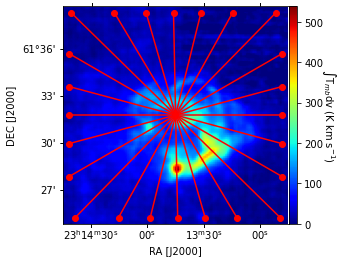

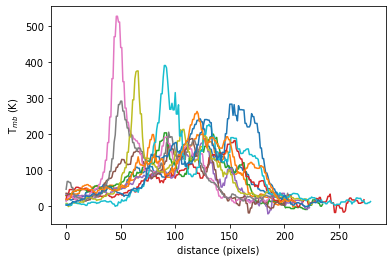

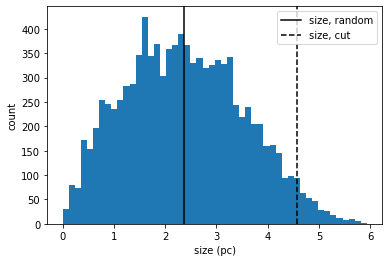

No handles with labels found to put in legend.


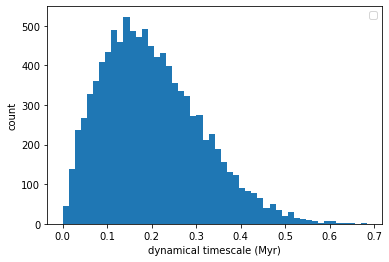

Filename: ../allRegions/final/RCW49_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (177, 254)   float32   
4160.0
Filename: ../allRegions/RCW49_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (177, 254, 400)   float32   


342
354
395
484
571
512
496
515
575
484
395
354
Bbox(x0=0.33712598425196855, y0=0.125, x1=0.6878740157480314, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

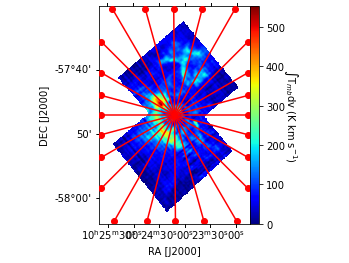

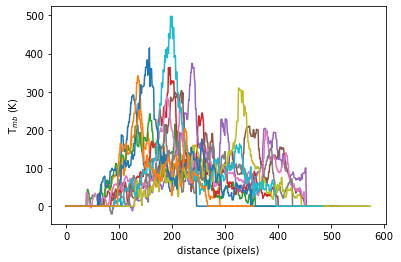

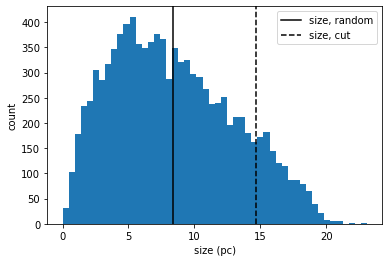

No handles with labels found to put in legend.


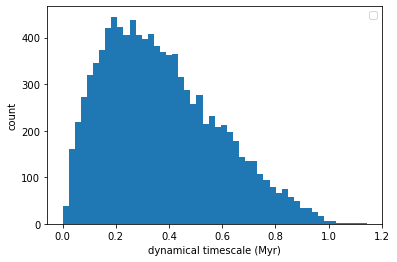

Filename: ../allRegions/final/OrionA_CII_final_20_8_0p5_clean_integrated.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   (1151, 1520)   float32   
414.0
Filename: ../allRegions/OrionA_CII_final_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (1151, 1520, 519)   float32   


1428
1478
2533
1790
1462
1312
1268
1314
1466
1796
2539
1478
Bbox(x0=0.229375, y0=0.125, x1=0.795625, y1=0.88)
0.88


<ipython-input-4-ac27378c0fc9>:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  zi = dat[y.astype(np.int)-yb, x.astype(np.int)-xb]


<Figure size 432x288 with 0 Axes>

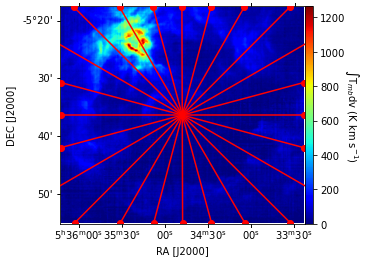

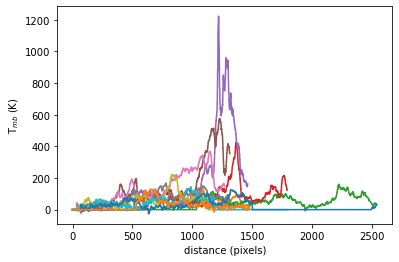

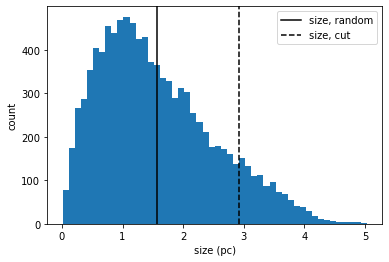

No handles with labels found to put in legend.


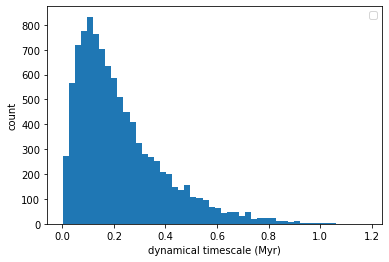

<Figure size 432x288 with 0 Axes>

In [5]:
avSizeList = []
avSizeErrList = []
altSizeList = []
altSizeErrList = []

clusterAgeList = []
clusterAgeListMin = []
clusterAgeListMax = []

dynAgeList = []
dynAgeList_MC = []
dynAgeErrListMin = []
dynAgeErrListMax = []
dynAgeErrListMin_MC = []
dynAgeErrListMax_MC = []
dynAgeListFWHM = []
dynAgeErrListFWHMMin = []
dynAgeErrListFWHMMax = []

altDynAgeList = []
altDynAgeErrListMin = []
altDynAgeErrListMax = []
altDynAgeListFWHM = []
altDynAgeErrListFWHMMin = []
altDynAgeErrListFWHMMax = []

vExpList = []
vExpErrListMax = []
vExpErrListMin = []
vExpListFWHM = []
vExpErrListFWHMMax = []
vExpErrListFWHMMin = []

regionNames = []

## calculate the size for each region
for name in names:
    hdu = pyfits.open('../allRegions/final/'+name+'_integrated.fits')
    hdu.info()
    data = hdu[0].data
    header = hdu[0].header
    w = wcs.WCS(header)
    print(names[name][0])
    pixSize = names[name][0]*header['CDELT2']*np.pi/180.
    
    try:
        hdu = pyfits.open('../allRegions/'+name+'.fits')
    except FileNotFoundError as ferr:
        hdu = pyfits.open('../allRegions/non-FEEDBACK/'+name+'.fits')
    hdu.info()
    cube = hdu[0].data
    headerCube = hdu[0].header
    crval = headerCube['CRVAL3']/1000.
    cdelt = headerCube['CDELT3']/1000.
    crpix = headerCube['CRPIX3']
    
    ## create velocity array (array)
    velArr = np.array([crval + 0.5*cdelt + cdelt*(i-crpix) for i in range(0,len(cube))])
    #print(velArr)
    
    regionNames.append(names[name][10])
    
    if(name=='OrionA_CII_final_20_8_0p5_clean'):
        data[:,0:x1_M42] = np.nan
        data[:,x2_M42:len(data[0])] = np.nan
        data[0:y1_M42,:] = np.nan
        data[y2_M42:len(data),:] = np.nan
        cube[:,:,0:x1_M42] = np.nan
        cube[:,:,x2_M42:len(data[0])] = np.nan
        cube[:,0:y1_M42,:] = np.nan
        cube[:,y2_M42:len(data),:] = np.nan
    
    datac = data.copy()
    data[data<vmin] = np.nan
    indices = np.argwhere(~np.isnan(data))
    #print(indices[0])
    
    ## create the average spectrum for the region (array)
    spec = np.nanmean(cube,axis=(1,2))
    
    ## get the spectrum and velocity axes of the blue and redshifted wings (4 arrays)
    zminB = int((names[name][4]-crval)/cdelt + crpix + 0.5)
    zmaxB = int((names[name][5]-crval)/cdelt + crpix + 0.5)
    zminR = int((names[name][6]-crval)/cdelt + crpix + 0.5)
    zmaxR = int((names[name][7]-crval)/cdelt + crpix + 0.5)
    #velArrB = velArr[zminB:zmaxB+1]
    velArrB = velArr[zminB:zmaxB]
    specB = spec[zminB:zmaxB]
    #velArrR = velArr[zminR:zmaxR+1]
    velArrR = velArr[zminR:zmaxR]
    specR = spec[zminR:zmaxR]
    velArrW = np.append(velArrB,velArrR)
    specW = np.append(specB,specR)
    #print(velArrW)
    
    ## create random velocity sample
    cdf = np.cumsum(specW)
    cdf = cdf/cdf[-1]
    values = np.random.rand(sampleSize)
    vel_inds = np.searchsorted(cdf,values)
    velArrW_random = velArrW[vel_inds]
    
    ## convert the array to expansion velocities
    vB = 0.5*(names[name][4] + names[name][5])
    vR = 0.5*(names[name][6] + names[name][7])
    vCent = 0.5*(vB + vR)
    vel_exp_random = np.abs(velArrW_random - vCent)
    vExp = np.nanmean(vel_exp_random)
    
    
    dList = []
    for i in range(0,sampleSize):
        vals = random.choices(indices,k=2)
        #print(vals)
        x1 = vals[0][0]
        y1 = vals[0][1]
        x2 = vals[1][0]
        y2 = vals[1][1]
        d = np.sqrt((x2-x1)**2 + (y2-y1)**2)*pixSize*0.5*corrFactSize ## times 0.5 to get radius
        dList.append(d)
    #print(len(vel_exp_random))
    #print(len(dList))
    avSize = np.average(dList)
    avSizeErr = np.nanstd(dList)
    
    ## alternative way of getting size
    altSize = 0.
    attSizeErr = 0.
    if(name=='OrionA_CII_final_20_8_0p5_clean'):
        altSize, altSizeErr = avSizeFromCuts(x1_M42,x2_M42,y1_M42,y2_M42,dtheta,numCuts,datac,w,name)
    else:
        altSize, altSizeErr = avSizeFromCuts(0,len(data[0]),0,len(data),dtheta,numCuts,datac,w,name)
    if(name == 'RCW36_CII_final_20_8_0p5_clean'):
        altSize = 2.*avSize
        altSizeErr = 2.*avSizeErr
    altSizeList.append(altSize)
    altSizeErrList.append(altSizeErr)
    
    ## add exceptions to get the average size (e.g. incomplete map)
    if(names[name] == 'RCW36_CII_final_20_8_0p5_clean'):
        avSize = 2.*avSize
        avSizeErr = 2.*avSizeErr
    
    avSizeList.append(avSize)
    avSizeErrList.append(avSizeErr)
    
    
    ## still calculate the timescale from the velocity
    #vB = 0.5*(names[name][4] + names[name][5])
    #vR = 0.5*(names[name][6] + names[name][7])
    dvB = 0.33*0.5*(names[name][5] - names[name][4]) ## assume that full wing width corresponds to 3sigma uncertainty
    dvR = 0.33*0.5*(names[name][7] - names[name][6])
    #vExp = 0.5*(vR-vB)
    vExpFWHM = names[name][8]
    vExpListFWHM.append(vExpFWHM)
    #print(vExp)
    vExpList.append(vExp)
    #vCent = 0.5*(vR+vB)
    
    vExpErr = 0.5*(dvB+dvR)
    #print(vExpErr)
    vExpErrListMax.append(vExpErr)
    vExpErrListMin.append(vExpErr)
    vExpErrFWHM = names[name][9]
    vExpErrListFWHMMin.append(vExpErrFWHM)
    vExpErrListFWHMMax.append(vExpErrFWHM)
    
    ## calculate dynamical timescales from MC work (note that the distributions are clearly not always Gaussian)
    dyn_ages_MC = np.array(dList/vel_exp_random)
    dyn_age_MC = np.nanmean(dyn_ages_MC)
    dyn_age_MC_err = np.nanstd(dyn_ages_MC)
    if(names[name] == 'RCW36_CII_final_20_8_0p5_clean'):
        dyn_age_MC = 2.*dyn_age_MC
        dyn_age_MC_err = 2.*dyn_age_MC_err
    dynAgeList_MC.append(dyn_age_MC)
    dynAgeErrListMin_MC.append(dyn_age_MC)
    dynAgeErrListMax_MC.append(dyn_age_MC)
    
    
    dynAge = avSize/vExp
    dynAgeList.append(dynAge)
    dynAgeErr = dynAge*np.sqrt((vExpErr/vExp)**2 + (avSizeErr/avSize)**2)
    dynAgeErrListMin.append(dynAgeErr)
    dynAgeErrListMax.append(dynAgeErr)
    
    altDynAge = altSize/vExp
    altDynAgeList.append(altDynAge)
    altDynAgeErr = altDynAge*np.sqrt((vExpErr/vExp)**2 + (altSizeErr/altSize)**2)
    altDynAgeErrListMin.append(altDynAgeErr)
    altDynAgeErrListMax.append(altDynAgeErr)
    
    dynAgeFWHM = avSize/vExpFWHM
    dynAgeListFWHM.append(dynAgeFWHM)
    dynAgeErrFWHM = dynAgeFWHM*np.sqrt((vExpErrFWHM/vExpFWHM)**2 + (avSizeErr/avSize)**2)
    dynAgeErrListFWHMMin.append(dynAgeErrFWHM)
    dynAgeErrListFWHMMax.append(dynAgeErrFWHM)
    
    altDynAgeFWHM = altSize/vExpFWHM
    altDynAgeListFWHM.append(altDynAgeFWHM)
    altDynAgeErrFWHM = altDynAgeFWHM*np.sqrt((vExpErrFWHM/vExpFWHM)**2 + (altSizeErr/altSize)**2)
    altDynAgeErrListFWHMMin.append(altDynAgeErrFWHM)
    altDynAgeErrListFWHMMax.append(altDynAgeErrFWHM)
    
    
    ## add the cluster age
    clusterAgeList.append(names[name][2])
    clusterAgeListMin.append(names[name][1])
    clusterAgeListMax.append(names[name][3])
    
    ## plot the histogram
    plt.hist(dList,bins=50)
    plt.axvline(x=avSize,color='k',label='size, random')
    plt.axvline(x=altSize,color='k',linestyle='--',label='size, cut')
    plt.xlabel('size (pc)')
    plt.ylabel('count')
    plt.legend()
    plt.show()
    plt.clf()
    
    plt.hist(dyn_ages_MC,bins=50)
    #plt.axvline(x=avSize,color='k',label='size, random')
    #plt.axvline(x=altSize,color='k',linestyle='--',label='size, cut')
    plt.xlabel('dynamical timescale (Myr)')
    plt.ylabel('count')
    plt.legend()
    plt.show()
    plt.clf()
    
    #dataRav = data.ravel()
    #dataRav = dataRav[~np.isnan(dataRav)]
    #print(len(dataRav))

In [6]:
## calculate error and dynamics timescale with Monte Carlo
# https://stackoverflow.com/questions/17821458/random-number-from-histogram
# for spectrum: https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

In [7]:
## calculate the age difference
ageDiffList = []
ageDiffListMin = []
ageDiffListMax = []

altAgeDiffList = []
altAgeDiffListMin = []
altAgeDiffListMax = []

ageDiffListFWHM = []
ageDiffListFWHMMin = []
ageDiffListFWHMMax = []

altAgeDiffListFWHM = []
altAgeDiffListFWHMMin = []
altAgeDiffListFWHMMax = []

for d1, d1a, dFWHM, dFWHMa, a1, d1Min, d1Max, d1aMin, d1aMax, dFWHMMin, dFWHMMax, dFWHMaMin, dFWHMaMax, a1Min, a1Max in zip(dynAgeList,altDynAgeList,dynAgeListFWHM,altDynAgeListFWHM,clusterAgeList,dynAgeErrListMin,dynAgeErrListMax,altDynAgeErrListMin,altDynAgeErrListMax,dynAgeErrListFWHMMin,dynAgeErrListFWHMMax,altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax,clusterAgeListMin,clusterAgeListMax):
    ageDiffList.append(a1-d1)
    ageDiffListMin.append(np.sqrt(a1Min**2 + d1Min**2))
    ageDiffListMax.append(np.sqrt(a1Max**2 + d1Max**2))
    
    altAgeDiffList.append(a1-d1a)
    altAgeDiffListMin.append(np.sqrt(a1Min**2 + d1aMin**2))
    altAgeDiffListMax.append(np.sqrt(a1Max**2 + d1aMax**2))
    
    ageDiffListFWHM.append(a1-dFWHM)
    ageDiffListFWHMMin.append(np.sqrt(a1Min**2 + dFWHMMin**2))
    ageDiffListFWHMMax.append(np.sqrt(a1Max**2 + dFWHMMax**2))
    
    altAgeDiffListFWHM.append(a1-dFWHMa)
    altAgeDiffListFWHMMin.append(np.sqrt(a1Min**2 + dFWHMaMin**2))
    altAgeDiffListFWHMMax.append(np.sqrt(a1Max**2 + dFWHMaMax**2))

In [8]:
## fit linear function to data
data1 = RealData(clusterAgeList,ageDiffList,sx=clusterAgeListMin,sy=ageDiffListMin)
linear = Model(linFunc)
odr1 = ODR(data1,linear,beta0=[1.,0.5])
output1 = odr1.run()
output1.pprint()
x1 = np.linspace(0.,3.,10)
y1 = linFunc(output1.beta, x1)

linear_no = Model(linFunc_noOff)
odr1_no = ODR(data1,linear_no,beta0=[1.])
output1_no = odr1_no.run()
output1_no.pprint()
x1_no = np.linspace(0.,3.,10)
y1_no = linFunc_noOff(output1_no.beta, x1_no)

print("#####")
print(" ")
print("#####")

data1a = RealData(clusterAgeList,altAgeDiffList,sx=clusterAgeListMin,sy=altAgeDiffListMin)
linear = Model(linFunc)
odr1 = ODR(data1a,linear,beta0=[1.,0.5])
output1a = odr1.run()
output1a.pprint()
x1a = np.linspace(0.,3.,10)
y1a = linFunc(output1a.beta, x1a)

linear_no = Model(linFunc_noOff)
odr1_no = ODR(data1a,linear_no,beta0=[1.])
output1a_no = odr1_no.run()
output1a_no.pprint()
x1a_no = np.linspace(0.,3.,10)
y1a_no = linFunc_noOff(output1a_no.beta, x1a_no)

print("#####")
print(" ")
print("#####")


dataFWHM = RealData(clusterAgeList,ageDiffListFWHM,sx=clusterAgeListMin,sy=ageDiffListFWHMMin)
linear = Model(linFunc)
odrFWHM = ODR(dataFWHM,linear,beta0=[1.,0.5])
outputFWHM = odrFWHM.run()
outputFWHM.pprint()
xFWHM = np.linspace(0.,3.,10)
yFWHM = linFunc(outputFWHM.beta, xFWHM)

linear_no = Model(linFunc_noOff)
odrFWHM_no = ODR(dataFWHM,linear_no,beta0=[1.])
outputFWHM_no = odrFWHM_no.run()
outputFWHM_no.pprint()
xFWHM_no = np.linspace(0.,3.,10)
yFWHM_no = linFunc_noOff(outputFWHM_no.beta, xFWHM_no)

print("#####")
print(" ")
print("#####")

dataFWHMa = RealData(clusterAgeList,altAgeDiffListFWHM,sx=clusterAgeListMin,sy=altAgeDiffListFWHMMin)
linear = Model(linFunc)
odrFWHM = ODR(dataFWHMa,linear,beta0=[1.,0.5])
outputFWHMa = odrFWHM.run()
outputFWHMa.pprint()
xFWHMa = np.linspace(0.,3.,10)
yFWHMa = linFunc(outputFWHMa.beta, xFWHMa)

linear_no = Model(linFunc_noOff)
odrFWHM_no = ODR(dataFWHMa,linear_no,beta0=[1.])
outputFWHMa_no = odrFWHM_no.run()
outputFWHMa_no.pprint()
xFWHMa_no = np.linspace(0.,3.,10)
yFWHMa_no = linFunc_noOff(outputFWHMa_no.beta, xFWHMa_no)

Beta: [ 0.96287336 -0.2622639 ]
Beta Std Error: [0.06524451 0.08054974]
Beta Covariance: [[ 0.08255859 -0.08810216]
 [-0.08810216  0.12583533]]
Residual Variance: 0.051561517494788545
Inverse Condition #: 0.2535956541487346
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.78544534]
Beta Std Error: [0.04898694]
Beta Covariance: [[0.01798905]]
Residual Variance: 0.13339897087598263
Inverse Condition #: 1.0000000000000002
Reason(s) for Halting:
  Sum of squares convergence
#####
 
#####
Beta: [ 1.01074263 -0.60081762]
Beta Std Error: [0.10654287 0.13106739]
Beta Covariance: [[ 0.0867426  -0.09192966]
 [-0.09192966  0.13127225]]
Residual Variance: 0.13086284962023306
Inverse Condition #: 0.2559588080927799
Reason(s) for Halting:
  Sum of squares convergence
Beta: [0.61733835]
Beta Std Error: [0.10145881]
Beta Covariance: [[0.0162969]]
Residual Variance: 0.6316473388249768
Inverse Condition #: 0.9999999999999999
Reason(s) for Halting:
  Sum of squares convergence
#####
 
#####
B

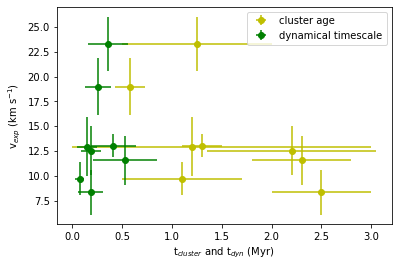

In [9]:
plt.errorbar(clusterAgeList,vExpList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList,vExpList,xerr=[dynAgeErrListMin,dynAgeErrListMax], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='g',label='dynamical timescale')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

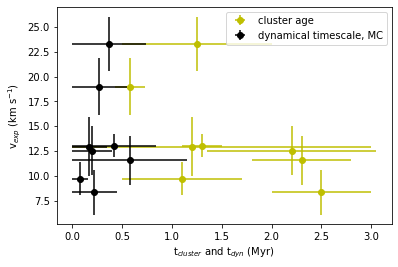

In [10]:
plt.errorbar(clusterAgeList,vExpList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList_MC,vExpList,xerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='k',label='dynamical timescale, MC')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

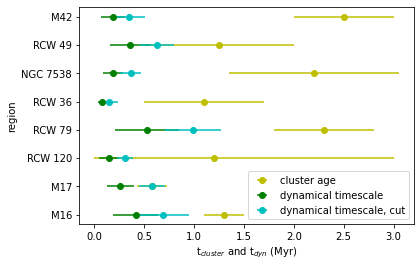

In [11]:
plt.errorbar(clusterAgeList,regionNames,xerr=[clusterAgeListMin,clusterAgeListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList,regionNames,xerr=[dynAgeErrListMin,dynAgeErrListMax],fmt='o',color='g',label='dynamical timescale')
plt.errorbar(altDynAgeList,regionNames,xerr=[altDynAgeErrListMin,altDynAgeErrListMax],fmt='o',color='c',label='dynamical timescale, cut')
plt.ylabel('region')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_4.pdf',dpi=300)
plt.show()

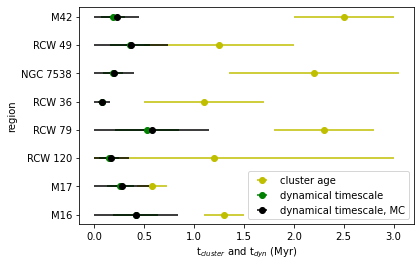

In [12]:
plt.errorbar(clusterAgeList,regionNames,xerr=[clusterAgeListMin,clusterAgeListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeList,regionNames,xerr=[dynAgeErrListMin,dynAgeErrListMax],fmt='o',color='g',label='dynamical timescale')
plt.errorbar(dynAgeList_MC,regionNames,xerr=[dynAgeErrListMin_MC,dynAgeErrListMax_MC],fmt='o',color='k',label='dynamical timescale, MC')
plt.ylabel('region')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_4.pdf',dpi=300)
plt.show()

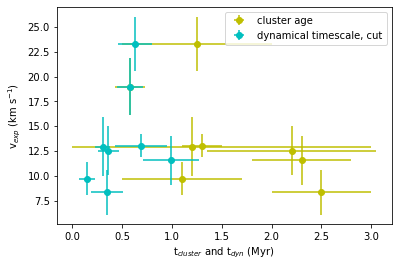

In [13]:
plt.errorbar(clusterAgeList,vExpList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(altDynAgeList,vExpList,xerr=[altDynAgeErrListMin,altDynAgeErrListMax], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='c',label='dynamical timescale, cut')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

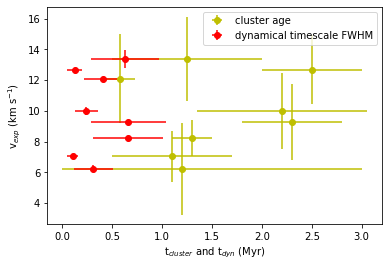

In [14]:
plt.errorbar(clusterAgeList,vExpListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeListFWHM,vExpListFWHM,xerr=[dynAgeErrListFWHMMin,dynAgeErrListFWHMMax], yerr=[vExpErrListFWHMMin,vExpErrListFWHMMax],fmt='o',color='r',label='dynamical timescale FWHM')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

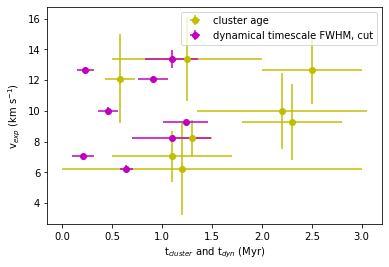

In [15]:
plt.errorbar(clusterAgeList,vExpListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[vExpErrListMin,vExpErrListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(altDynAgeListFWHM,vExpListFWHM,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax], yerr=[vExpErrListFWHMMin,vExpErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

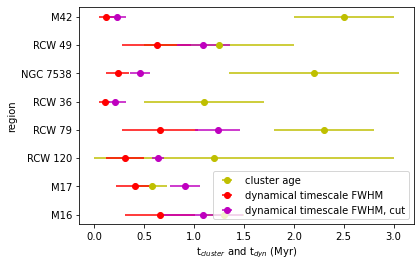

In [16]:
plt.errorbar(clusterAgeList,regionNames,xerr=[clusterAgeListMin,clusterAgeListMax], fmt='o',color='y',label='cluster age')
plt.errorbar(dynAgeListFWHM,regionNames,xerr=[dynAgeErrListFWHMMin,dynAgeErrListFWHMMax],fmt='o',color='r',label='dynamical timescale FWHM')
plt.errorbar(altDynAgeListFWHM,regionNames,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('region')
plt.xlabel('t$_{cluster}$ and t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_3.pdf',dpi=300)
plt.show()

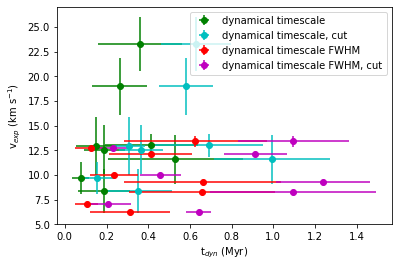

In [17]:
## compare the different methods to calculate the dynamical age
plt.errorbar(dynAgeList,vExpList,xerr=[dynAgeErrListMin,dynAgeErrListMax], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='g',label='dynamical timescale')
plt.errorbar(altDynAgeList,vExpList,xerr=[altDynAgeErrListMin,altDynAgeErrListMax], yerr=[vExpErrListMin,vExpErrListMax],fmt='o',color='c',label='dynamical timescale, cut')
plt.errorbar(dynAgeListFWHM,vExpListFWHM,xerr=[dynAgeErrListFWHMMin,dynAgeErrListFWHMMax], yerr=[vExpErrListFWHMMin,vExpErrListFWHMMax],fmt='o',color='r',label='dynamical timescale FWHM')
plt.errorbar(altDynAgeListFWHM,vExpListFWHM,xerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax], yerr=[vExpErrListFWHMMin,vExpErrListFWHMMax],fmt='o',color='m',label='dynamical timescale FWHM, cut')
plt.ylabel('v$_{exp}$ (km s$^{-1}$)')
plt.xlabel('t$_{dyn}$ (Myr)')

plt.legend()
#plt.savefig('test_dyn_age.pdf',dpi=300)
plt.show()

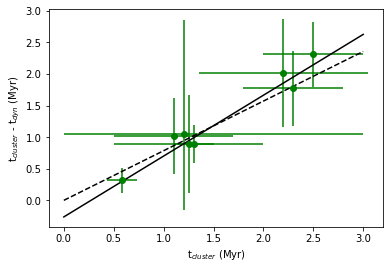

In [18]:
plt.errorbar(clusterAgeList,ageDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListMin,ageDiffListMax], fmt='o',color='g')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(x1,y1,'k-')
plt.plot(x1_no,y1_no,'k--')

#plt.legend()
#plt.savefig('test_1.pdf',dpi=300)
plt.show()

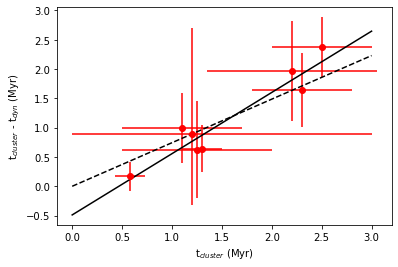

In [19]:
plt.errorbar(clusterAgeList,ageDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListFWHMMin,ageDiffListFWHMMax], fmt='o',color='r')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(xFWHM,yFWHM,'k-')
plt.plot(xFWHM_no,yFWHM_no,'k--')

#plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

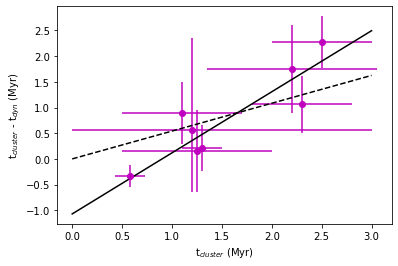

In [20]:
plt.errorbar(clusterAgeList,altAgeDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListFWHMMin,altAgeDiffListFWHMMax], fmt='o',color='m')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(xFWHMa,yFWHMa,'k-')
plt.plot(xFWHMa_no,yFWHMa_no,'k--')

#plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

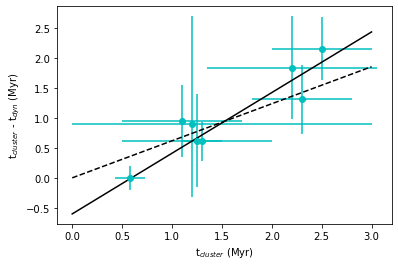

In [21]:
plt.errorbar(clusterAgeList,altAgeDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListMin,altAgeDiffListMax], fmt='o',color='c')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')
plt.plot(x1a,y1a,'k-')
plt.plot(x1a_no,y1a_no,'k--')

#plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

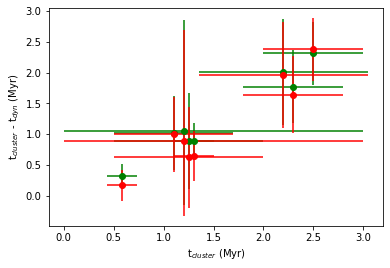

In [22]:
plt.errorbar(clusterAgeList,ageDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListMin,ageDiffListMax], fmt='o',color='g')
plt.errorbar(clusterAgeList,ageDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListFWHMMin,ageDiffListFWHMMax], fmt='o',color='r')
plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

#plt.legend()
#plt.savefig('test.pdf',dpi=300)
plt.show()

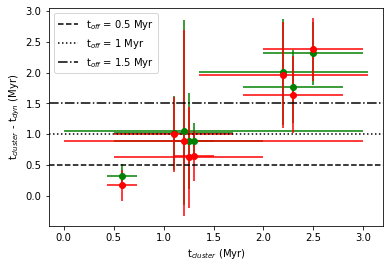

In [23]:
plt.errorbar(clusterAgeList,ageDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListMin,ageDiffListMax], fmt='o',color='g')
plt.errorbar(clusterAgeList,ageDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[ageDiffListFWHMMin,ageDiffListFWHMMax], fmt='o',color='r')

plt.axhline(y=0.5,color='k',linestyle = '--',label='t$_{off}$ = 0.5 Myr')
plt.axhline(y=1.,color='k',linestyle = ':',label='t$_{off}$ = 1 Myr')
plt.axhline(y=1.5,color='k',linestyle = '-.',label='t$_{off}$ = 1.5 Myr')

plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.legend(loc=2)
#plt.savefig('test.pdf',dpi=300)
plt.show()

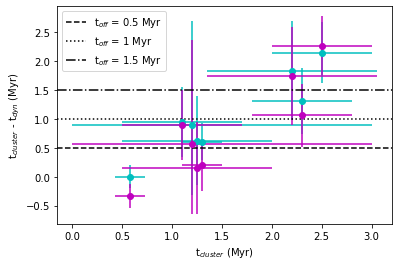

In [24]:
plt.errorbar(clusterAgeList,altAgeDiffList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListMin,altAgeDiffListMax], fmt='o',color='c')
plt.errorbar(clusterAgeList,altAgeDiffListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altAgeDiffListFWHMMin,altAgeDiffListFWHMMax], fmt='o',color='m')

plt.axhline(y=0.5,color='k',linestyle = '--',label='t$_{off}$ = 0.5 Myr')
plt.axhline(y=1.,color='k',linestyle = ':',label='t$_{off}$ = 1 Myr')
plt.axhline(y=1.5,color='k',linestyle = '-.',label='t$_{off}$ = 1.5 Myr')

plt.ylabel('t$_{cluster}$ - t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.legend(loc=2)
#plt.savefig('test.pdf',dpi=300)
plt.show()

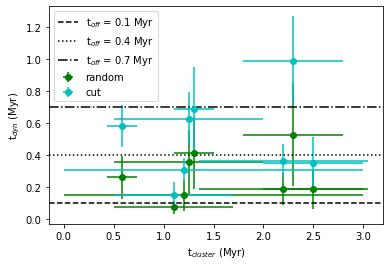

In [25]:
plt.errorbar(clusterAgeList,dynAgeList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[dynAgeErrListMin,dynAgeErrListMax], fmt='o',color='g',label='random')
plt.errorbar(clusterAgeList,altDynAgeList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altDynAgeErrListMin,altDynAgeErrListMax], fmt='o',color='c',label='cut')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='t$_{off}$ = 0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='t$_{off}$ = 0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='t$_{off}$ = 0.7 Myr')

plt.legend()

plt.show()

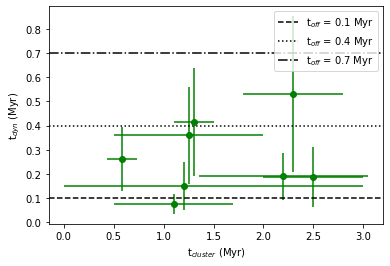

In [26]:
plt.errorbar(clusterAgeList,dynAgeList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[dynAgeErrListMin,dynAgeErrListMax], fmt='o',color='g')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='t$_{off}$ = 0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='t$_{off}$ = 0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='t$_{off}$ = 0.7 Myr')

plt.legend()

#plt.savefig('test_2.pdf',dpi=300)
plt.show()

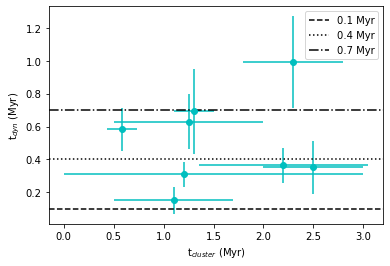

In [27]:
plt.errorbar(clusterAgeList,altDynAgeList,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altDynAgeErrListMin,altDynAgeErrListMax], fmt='o',color='c')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='0.7 Myr')

plt.legend()

plt.show()

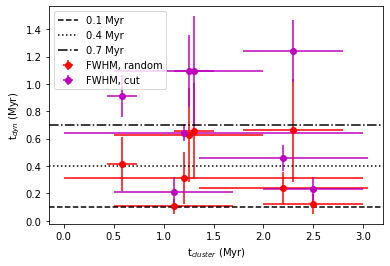

In [28]:
plt.errorbar(clusterAgeList,dynAgeListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[dynAgeErrListFWHMMin,dynAgeErrListFWHMMax], fmt='o',color='r',label='FWHM, random')
plt.errorbar(clusterAgeList,altDynAgeListFWHM,xerr=[clusterAgeListMin,clusterAgeListMax], yerr=[altDynAgeErrListFWHMMin,altDynAgeErrListFWHMMax], fmt='o',color='m',label='FWHM, cut')

plt.ylabel('t$_{dyn}$ (Myr)')
plt.xlabel('t$_{cluster}$ (Myr)')

plt.axhline(y=0.1,color='k',linestyle = '--',label='0.1 Myr')
plt.axhline(y=0.4,color='k',linestyle = ':',label='0.4 Myr')
plt.axhline(y=0.7,color='k',linestyle = '-.',label='0.7 Myr')

plt.legend()

plt.show()